#### LoRA Fine-Tuning

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os
import random
import h5py
import pandas as pd
import time
import importlib
from pprint import pprint
import torch 
from tqdm import tqdm
from src.qwen import load_qwen
import re
import yaml
import gc
from torch.utils.data import TensorDataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print('Device-activated: ', device)
file_path = "data/lotka_volterra_data.h5"  # Change this to the correct path

Device-activated:  cpu


In [10]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              76
On-line CPU(s) list: 0-75
Thread(s) per core:  1
Core(s) per socket:  38
Socket(s):           2
NUMA node(s):        2
Vendor ID:           GenuineIntel
CPU family:          6
Model:               106
Model name:          Intel(R) Xeon(R) Platinum 8368Q CPU @ 2.60GHz
Stepping:            6
CPU MHz:             815.561
CPU max MHz:         3700.0000
CPU min MHz:         800.0000
BogoMIPS:            5200.00
L1d cache:           48K
L1i cache:           32K
L2 cache:            1280K
L3 cache:            58368K
NUMA node0 CPU(s):   0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74
NUMA node1 CPU(s):   1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush d

In [27]:
import src
import src.data_prepare
import src.forecast 
import src.preprocess
import src.lora 
import src.data_create

importlib.reload(src)
importlib.reload(src.forecast)
importlib.reload(src.preprocess)
importlib.reload(src.lora)
importlib.reload(src.data_create)
importlib.reload(src.data_prepare)

from src.forecast import *
from src.lora import LoRALinear
from src.preprocess import *
from src.data_create import *
from src.data_prepare import *

In [12]:
random_state = 28
np.random.seed(random_state)

Can directly load modified model --> LoRATrainer.get_model()  

In [13]:
ft = time.time()
model_lora, tokenizer = load_qwen()
lt = time.time()

print('time-taken: ', (lt - ft)/60, 'mins') 

pprint(model_lora.config)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


time-taken:  0.1755311171213786 mins
Qwen2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Qwen/Qwen2.5-0.5B-Instruct",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}



In [14]:
def load_config(config_path):
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config

manual_config = load_config("src/config.yaml")

In [ ]:

train_split = manual_config['train_split']
time_step_split = manual_config['time_step_split']
batch_size = manual_config['batch_size']
learning_rate = manual_config['learning_rate'] # 1e-5
lora_rank = manual_config['lora_rank']
max_ctx_length = manual_config['seq_length']
forecast_length = manual_config['forecast_length']
max_tokens = manual_config['seq_length']

In [16]:
### NO: test-train split because of chunking later
data_prey, data_prey_true, data_pred, data_pred_true, time_data_past, time_data_true = load_data(file_path, time_step_split, is_plot = True)
print(data_prey.shape, data_prey_true.shape, data_pred.shape, data_pred_true.shape, time_data_past.shape, time_data_true.shape)

Keys in HDF5 file: ['time', 'trajectories']
(1000, 80) (1000, 21) (1000, 80) (1000, 21) (80,) (21,)


In [17]:
check_rn = random.randint(0, len(data_prey))
print('check_rn: ', check_rn)

check_rn:  166


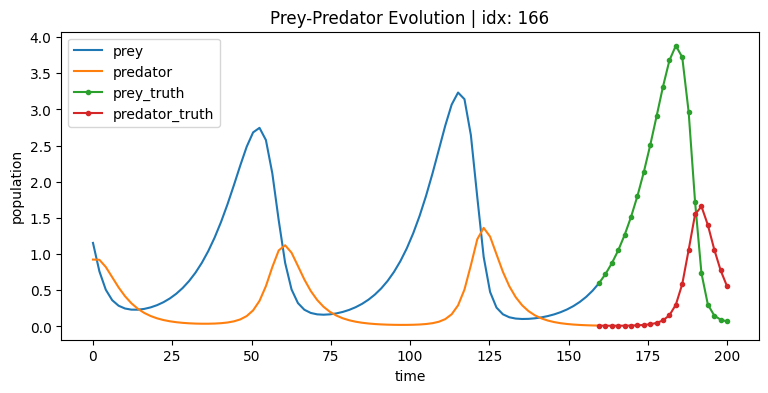

In [18]:
fig = plt.figure(figsize=(9, 4))

plt.plot(time_data_past, data_prey[check_rn], label = 'prey')
plt.plot(time_data_past, data_pred[check_rn], label = 'predator')

plt.plot(time_data_true, data_prey_true[check_rn], label = 'prey_truth', marker = '.')
plt.plot(time_data_true, data_pred_true[check_rn], label = 'predator_truth', marker = '.')

plt.xlabel('time')
plt.ylabel('population')

plt.legend()
plt.title(f'Prey-Predator Evolution | idx: {check_rn}')
plt.show()

In [19]:
# model_lora.config.max_position_embeddings = manual_config['seq_length']
model_lora.config.num_hidden_layers = manual_config['hidden_layers']

##### Dataset-Creation (Can't use the Untrained Qwen Preprocessing Module --> Because this one does a decoding-only chunking)

In [28]:
train_input_ids, train_target_ids, val_input_ids, val_target_ids, prey_os, pred_os, test_encoded = prepare_data(data_prey, data_pred, tokenizer, max_ctx_length, train_split, forecast_length=forecast_length, is_forecast=True)
print(train_input_ids.shape, train_target_ids.shape, val_input_ids.shape, val_target_ids.shape, test_encoded.shape)

---- Example-Prompt ----

PROMPT: 
<|im_start|>user
Predict the next prey and predator populations based on the historical data.
Historical data:  0.354, 0.978  0.282, 0.843  0.251, 0.7  0.239, 0.577  0.237, 0.478<|im_end|>
<|im_start|>assistant


TARGET: 
0.243, 0.401  0.256, 0.343  0.278, 0.301  0.311, 0.271  0.359, 0.251<|im_end|>
---- Example-Prompt ----

PROMPT: 
<|im_start|>user
Predict the next prey and predator populations based on the historical data.
Historical data:  0.234, 0.636  0.254, 0.48  0.301, 0.369  0.372, 0.296  0.465, 0.253<|im_end|>
<|im_start|>assistant


TARGET: 
0.577, 0.237  0.701, 0.245  0.823, 0.277  0.928, 0.338  0.996, 0.431<|im_end|>
torch.Size([30, 512]) torch.Size([30, 512]) torch.Size([15, 512]) torch.Size([15, 512]) ()


In [29]:
train_dataset = TensorDataset(train_input_ids, train_target_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids, val_target_ids)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [30]:
for batch_t, batch_v in zip(train_loader, val_loader):
    print(batch_t[0].shape, batch_v[0].shape)
    break

torch.Size([4, 512]) torch.Size([4, 512])


##### LoRA pre-training (we low-rank train the query and value projection matrices - retrain the attention networks)

In [31]:
# Apply LoRA to the model:
### replacing attention layers with trainable layers (r * in_dim) + (out_dim * r)
for layer in model_lora.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=manual_config['lora_rank']) 
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=manual_config['lora_rank'])

In [32]:
optimizer = torch.optim.Adam((p for p in model_lora.parameters() if p.requires_grad), lr=learning_rate)

In [33]:
def get_model_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total, trainable = get_model_params(model_lora)
print(f"Total Parameters: {total:,}")
print(f"Trainable Parameters: {trainable:,}") ## 100x lesser


Total Parameters: 494,455,040
Trainable Parameters: 422,272


##### Joint-Training

Do Model Checkpointing for Large Optimization Steps

In [34]:
# Prepare components with Accelerator
# accelerator = Accelerator()
# model_lora, optimizer, train_loader, val_loader = accelerator.prepare(model_lora, optimizer, train_loader, val_loader)

model_lora.train()

target_steps = manual_config['training_steps']  # Optimization Steps
print('Target-Train-Steps:', target_steps)

train_steps = 0
progress_bar = tqdm(range(target_steps), desc="Training Steps")

train_curve, val_curve = [], []

# best_val_loss = float('inf')
# checkpoint_freq = 5  # Save model every 5 steps - adjust this as needed

# # Create checkpoint directory if it doesn't exist
# checkpoint_dir = "model_checkpoints"
# os.makedirs(checkpoint_dir, exist_ok=True)

ft = time.time()

while train_steps < target_steps:
    for batch_input_ids, batch_target_ids in train_loader:
        optimizer.zero_grad()
        outputs = model_lora(batch_input_ids, labels=batch_target_ids)  # Use target_ids
        loss = outputs.loss  # Loss function is a model attribute
        loss.backward()
        optimizer.step()

        train_curve.append(loss.detach().cpu().item())  # Store loss for monitoring

        train_steps += 1
        progress_bar.update(1)
        progress_bar.set_postfix(loss=loss.item())
        
        # # Save checkpoint based on frequency
        # if train_steps % checkpoint_freq == 0:
        #     checkpoint_path = os.path.join(checkpoint_dir, f"lora_step_{train_steps}.pt")
        #     # Save LoRA adapter weights
        #     model_lora.save_pretrained(checkpoint_path)
        #     # Save optimizer state
        #     torch.save(optimizer.state_dict(), os.path.join(checkpoint_dir, f"optimizer_step_{train_steps}.pt"))
        #     print(f"Checkpoint saved at step {train_steps}")

    
        ### FOR EVERY TRAINING-STEP WE RUN V-B BATCH 0(T_B * V_B)
        # Validation Loop

        model_lora.eval()
        val_losses = []

        with torch.no_grad():
            for batch_input_ids, batch_target_ids in val_loader:
                val_op = model_lora(batch_input_ids, labels=batch_target_ids)
                val_losses.append(val_op.loss.cpu().item())
            
            # Calculate average validation loss
            avg_val_loss = sum(val_losses) / len(val_losses)
            val_curve.append(avg_val_loss)
            
            # # Save best model based on validation loss
            # if avg_val_loss < best_val_loss:
            #     best_val_loss = avg_val_loss
            #     best_model_path = os.path.join(checkpoint_dir, "best_model.pt")
            #     model_lora.save_pretrained(best_model_path)
            #     print(f"New best model saved with validation loss: {best_val_loss:.4f}")
        
        if train_steps >= target_steps:  # Stop training at the required steps
            break
        
        model_lora.train()  # Resume training mode
    
# # Save final model
# final_model_path = os.path.join(checkpoint_dir, "final_model.pt")
# model_lora.save_pretrained(final_model_path)

lt = time.time()
print('Time taken:', (lt - ft) / 60, 'mins')

model_lora.eval()

Target-Train-Steps: 10


Training Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Training Steps: 100%|██████████| 10/10 [06:43<00:00, 42.91s/it, loss=3.22]

Time taken: 7.222133469581604 mins


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): LoRALinear(
            (original_linear): Linear(in_features=896, out_features=896, bias=True)
          )
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): LoRALinear(
            (original_linear): Linear(in_features=896, out_features=128, bias=True)
          )
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm(

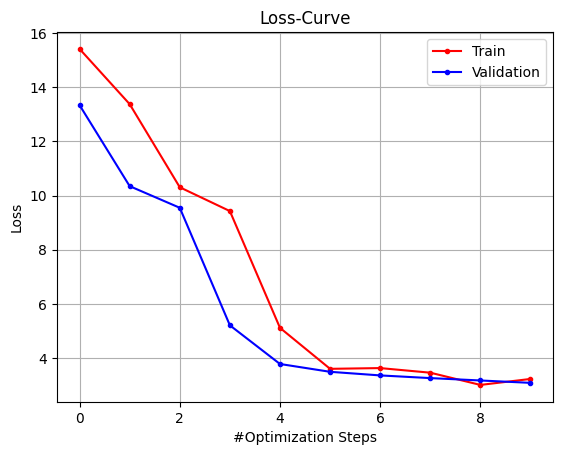

In [35]:
plt.plot(range(len(train_curve)), train_curve, color = 'red', marker = '.', label = 'Train')
plt.plot(range(len(val_curve)), val_curve, color = 'blue', marker = '.', label = 'Validation')

plt.ylabel('Loss')
plt.xlabel('#Optimization Steps')

plt.title('Loss-Curve')

plt.legend()
plt.grid()
plt.show()

Save weights - instead of the (architechture + weights)

In [ ]:
# ft = time.time()
# torch.save(model, f"saves/model_{target_steps}_{train_split}.pth")
# lt = time.time()

# print('time-taken: ', (lt - ft)/60, ' mins')

##### Loading Model

In [ ]:
# model_list = os.listdir('saves')
# path = os.path.join('saves', model_list[0])
# print('Load-File: ', path)

# model_lora = torch.load(path, weights_only=False)
# model_lora.eval()

#### NOTE: Performing Forecasting HERE

In [36]:
test_prompt = test_encoded
print('Test-Prompt: ')
print(test_prompt)

Test-Prompt: 
0.92, 0.861; 0.696, 0.993; 0.505, 1.027; 0.376, 0.974; 0.3, 0.874; 0.258, 0.759; 0.238, 0.646; 0.233, 0.545; 0.239, 0.459; 0.256, 0.387; 0.286, 0.329; 0.329, 0.286; 0.39, 0.256; 0.47, 0.239; 0.571, 0.237; 0.691, 0.252; 0.821, 0.29; 0.938, 0.357; 1.008, 0.459; 0.998, 0.597; 0.896, 0.747; 0.736, 0.87; 0.573, 0.928; 0.445, 0.915; 0.359, 0.85; 0.308, 0.761; 0.28, 0.665; 0.27, 0.574; 0.272, 0.493; 0.287, 0.425; 0.313, 0.37; 0.353, 0.327; 0.408, 0.297; 0.479, 0.281; 0.567, 0.279; 0.667, 0.294; 0.771, 0.329; 0.861, 0.39; 0.913, 0.477; 0.904, 0.588; 0.83, 0.705; 0.709, 0.802; 0.581, 0.851; 0.472, 0.848; 0.394, 0.802; 0.344, 0.731; 0.315, 0.652; 0.304, 0.574; 0.306, 0.503; 0.32, 0.443; 0.345, 0.393; 0.384, 0.355; 0.436, 0.329; 0.501, 0.316; 0.578, 0.318; 0.663, 0.335; 0.745, 0.371; 0.811, 0.428; 0.842, 0.505; 0.825, 0.597; 0.761, 0.689; 0.665, 0.76; 0.564, 0.795; 0.476, 0.789; 0.411, 0.751; 0.368, 0.693; 0.343, 0.627; 0.334, 0.561; 0.337, 0.5; 0.352, 0.448; 0.379, 0.406; 0.417, 0.

In [37]:
ft = time.time()

prey_pred_response = generate_forecast_v2(model_lora, test_prompt, tokenizer, inf_max_new_tokens=manual_config['inf_max_tokens'])
# prey_pred_response = generate_forecast(model_lora, test_prompt, tokenizer, max_new_tokens=max_tokens)

lt = time.time()

print('time-taken: ', (lt - ft) / 60)

PROMPT-ED:
<|im_start|>user
Predict the next prey and predator populations based on the historical data.
Historical data: 0.92, 0.861; 0.696, 0.993; 0.505, 1.027; 0.376, 0.974; 0.3, 0.874; 0.258, 0.759; 0.238, 0.646; 0.233, 0.545; 0.239, 0.459; 0.256, 0.387; 0.286, 0.329; 0.329, 0.286; 0.39, 0.256; 0.47, 0.239; 0.571, 0.237; 0.691, 0.252; 0.821, 0.29; 0.938, 0.357; 1.008, 0.459; 0.998, 0.597; 0.896, 0.747; 0.736, 0.87; 0.573, 0.928; 0.445, 0.915; 0.359, 0.85; 0.308, 0.761; 0.28, 0.665; 0.27, 0.574; 0.272, 0.493; 0.287, 0.425; 0.313, 0.37; 0.353, 0.327; 0.408, 0.297; 0.479, 0.281; 0.567, 0.279; 0.667, 0.294; 0.771, 0.329; 0.861, 0.39; 0.913, 0.477; 0.904, 0.588; 0.83, 0.705; 0.709, 0.802; 0.581, 0.851; 0.472, 0.848; 0.394, 0.802; 0.344, 0.731; 0.315, 0.652; 0.304, 0.574; 0.306, 0.503; 0.32, 0.443; 0.345, 0.393; 0.384, 0.355; 0.436, 0.329; 0.501, 0.316; 0.578, 0.318; 0.663, 0.335; 0.745, 0.371; 0.811, 0.428; 0.842, 0.505; 0.825, 0.597; 0.761, 0.689; 0.665, 0.76; 0.564, 0.795; 0.476, 0.78

In [38]:
print(type(prey_pred_response), len(prey_pred_response))
print(prey_pred_response)

<class 'str'> 2218
<|im_start|>user
Predict the next prey and predator populations based on the historical data.
Historical data: 0.92, 0.861; 0.696, 0.993; 0.505, 1.027; 0.376, 0.974; 0.3, 0.874; 0.258, 0.759; 0.238, 0.646; 0.233, 0.545; 0.239, 0.459; 0.256, 0.387; 0.286, 0.329; 0.329, 0.286; 0.39, 0.256; 0.47, 0.239; 0.571, 0.237; 0.691, 0.252; 0.821, 0.29; 0.938, 0.357; 1.008, 0.459; 0.998, 0.597; 0.896, 0.747; 0.736, 0.87; 0.573, 0.928; 0.445, 0.915; 0.359, 0.85; 0.308, 0.761; 0.28, 0.665; 0.27, 0.574; 0.272, 0.493; 0.287, 0.425; 0.313, 0.37; 0.353, 0.327; 0.408, 0.297; 0.479, 0.281; 0.567, 0.279; 0.667, 0.294; 0.771, 0.329; 0.861, 0.39; 0.913, 0.477; 0.904, 0.588; 0.83, 0.705; 0.709, 0.802; 0.581, 0.851; 0.472, 0.848; 0.394, 0.802; 0.344, 0.731; 0.315, 0.652; 0.304, 0.574; 0.306, 0.503; 0.32, 0.443; 0.345, 0.393; 0.384, 0.355; 0.436, 0.329; 0.501, 0.316; 0.578, 0.318; 0.663, 0.335; 0.745, 0.371; 0.811, 0.428; 0.842, 0.505; 0.825, 0.597; 0.761, 0.689; 0.665, 0.76; 0.564, 0.795; 0.4

In [ ]:
prey_decoded_response, pred_decoded_response = extract_forecasts(prey_pred_response)

print(len(prey_decoded_response), len(pred_decoded_response))
print(prey_decoded_response)

prey_decoded_response = ts_decoding(prey_decoded_response, model_type="llama", precision=3, offsets=prey_os['offset'][check_rn], scale_factors=prey_os['scale'][check_rn])[:forecast_length]
pred_decoded_response = ts_decoding(pred_decoded_response, model_type="llama", precision=3, offsets=pred_os['offset'][check_rn], scale_factors=pred_os['scale'][check_rn])[:forecast_length]

543 551
0.3, 0.25, 0.236, 0.244, 0.27, 0.313, 0.374, 0.456, 0.557, 0.675, 0.798, 0.912, 0.994, 1.021, 0.973, 0.849, 0.681, 0.522, 0.409, 0.345, 0.319, 0.318, 0.337, 0.374, 0.427, 0.495, 0.576, 0.664, 0.749, 0.818, 0.855, 0.848, 0.793, 0.699, 0.591, 0.496, 0.428, 0.39, 0.377, 0.384, 0.407, 0.445, 0.495, 0.554, 0.618, 0.68, 0.73, 0.758, 0.758, 0.726, 0.668, 0.597, 0.529, 0.475, 0.44, 0.425, 0.426, 0.442, 0.47, 0.508, 0.553, 0.6, 0.645, 0.68, 0.699, 0.699, 0.677, 0.638, 0.589, 0.541, 0.5, 0.473, 0.459, 0.459, 0.47, 0.492, 0.522, 0.556, 0.592, 0.624


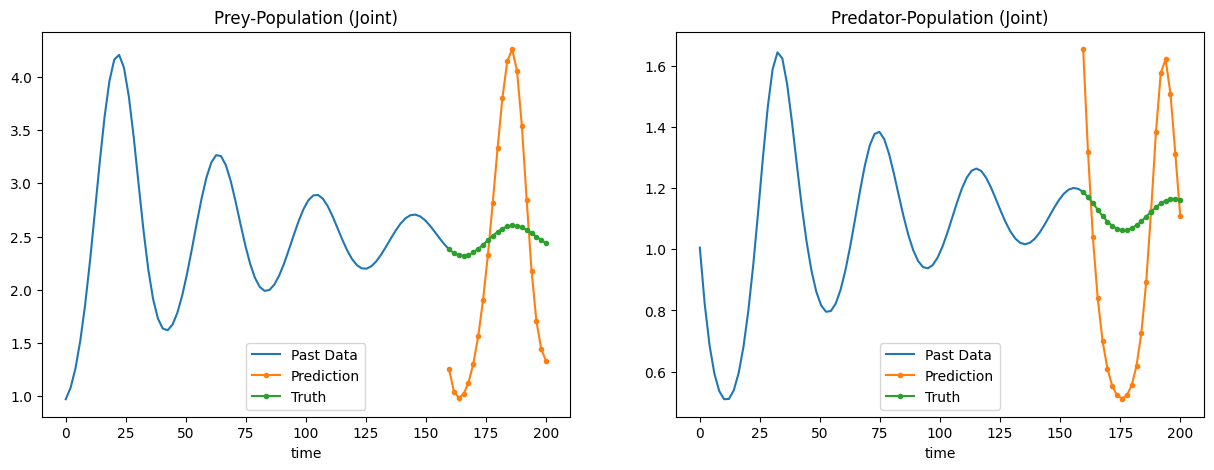

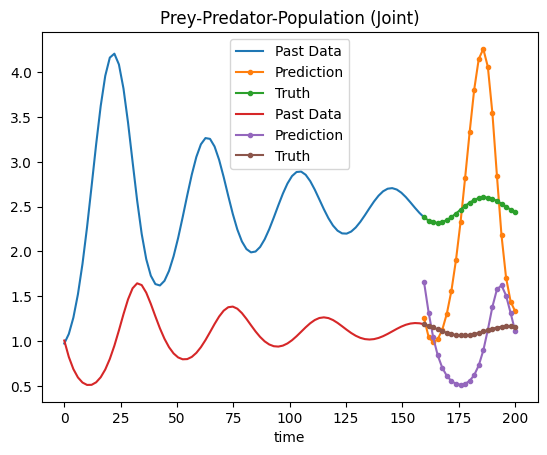

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(time_data_past, data_prey[check_rn].tolist(), label = 'Past Data')
axs[0].plot(time_data_true[:len(prey_decoded_response)], prey_decoded_response, label = 'Prediction', marker = '.')
axs[0].plot(time_data_true, data_prey_true[check_rn].tolist(), label = 'Truth', marker = '.')

axs[0].set_title('Prey-Population (Joint)')
axs[0].set_xlabel('time')
axs[0].legend()

axs[1].plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
axs[1].plot(time_data_true[:len(prey_decoded_response)], pred_decoded_response, label = 'Prediction', marker = '.')
axs[1].plot(time_data_true, data_pred_true[check_rn].tolist(), label = 'Truth', marker = '.')

axs[1].set_title('Predator-Population (Joint)')
axs[1].set_xlabel('time')
axs[1].legend()

plt.show()


''' 
Jointly show them in the same plot 
'''
print()

plt.plot(time_data_past, data_prey[check_rn].tolist(), label = 'Past Data')
plt.plot(time_data_true, prey_decoded_response, label = 'Prediction', marker = '.')
plt.plot(time_data_true, data_prey_true[check_rn].tolist(), label = 'Truth', marker = '.')

plt.plot(time_data_past, data_pred[check_rn].tolist(), label = 'Past Data')
plt.plot(time_data_true, pred_decoded_response, label = 'Prediction', marker = '.')
plt.plot(time_data_true, data_pred_true[check_rn].tolist(), label = 'Truth', marker = '.')

plt.xlabel('time')
plt.title('Prey-Predator-Population (Joint)')
plt.legend()
plt.show()
